In [1]:
!pip install -U datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_

In [1]:
!pip install datasets gradio torch torchvision --quiet
!pip install transformers --quiet --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter, defaultdict
import random
import numpy as np
from datasets import load_dataset

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
# ===============================
# 2. تحميل الداتا
# ===============================
dataset = load_dataset("ag_news") # Huggingface فيه كل خبر وتصنيفه

train_texts = [item["text"] for item in dataset["train"]] # بحط الخبر نفسه
train_labels = [item["label"] for item in dataset["train"]]# بحط تصنيف الخبر اي رقم التصنيف
test_texts = [item["text"] for item in dataset["test"]] # نفس الشي بس ذا للاختبار
test_labels = [item["label"] for item in dataset["test"]]

 Number of training samples: 120000
 Number of test samples: 7600

 Distribution of categories in training:
label_name
Business        30000
Science/Tech    30000
Sports          30000
World           30000
Name: count, dtype: int64

 Average length of texts: 37.84745


/tmp/ipython-input-11-410107093.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="label_name", order=df_train["label_name"].value_counts().index, palette="coolwarm")


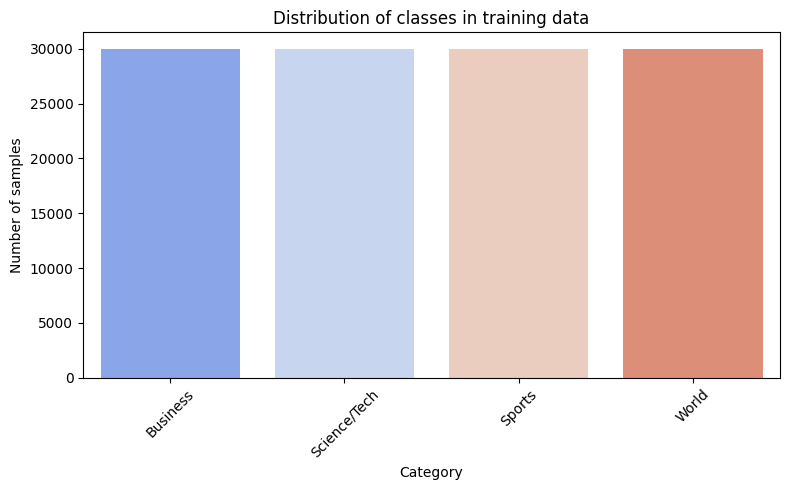

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = load_dataset("ag_news") # Huggingface فيه كل خبر وتصنيفه
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Tech"
}

df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

df_train["label_name"] = df_train["label"].map(label_map)
df_test["label_name"] = df_test["label"].map(label_map)

# ===============================
# 2. EDA التحليل
# ===============================

# عدد عينات التدريب والاختبار
print(" Number of training samples:", len(df_train))
print(" Number of test samples:", len(df_test))

# عدد الاخبار لكل فئه
print("\n Distribution of categories in training:")
print(df_train["label_name"].value_counts())

# متوسط طول النصوص
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
print("\n Average length of texts:", df_train["text_length"].mean())

# ===============================
# 3. سويت رسم بياني عشان اعرف الداتا متوازنة او لا
# ===============================
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x="label_name", order=df_train["label_name"].value_counts().index, palette="coolwarm")
plt.title("Distribution of classes in training data")
plt.xlabel("Category")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# طباعة 5 عينات عشوائية من بيانات التدريب
print(df_train.sample(5))


                                                     text  label label_name  \
116796  It #39;s been swell, Pedro Perhaps in our hear...      1     Sports   
39819   US soldiers flock to laser eye clinic FORT CAM...      0      World   
78339   MSU med school plan to move has flaws, study s...      2   Business   
38237   Viacom in China Tie-Up with Beijing TV (Reuter...      2   Business   
69271   Coulthard has one race to prove his worth Davi...      1     Sports   

        text_length  
116796           33  
39819            38  
78339            36  
38237            38  
69271            38  


In [13]:
# ===============================
# 3. تنظيف الداتا
# ===============================
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # إزالة الرموز
    text = re.sub(r"\d+", "", text)      # إزالة الأرقام
    return text.strip()
train_texts = [clean_text(t) for t in train_texts]
test_texts = [clean_text(t) for t in test_texts]


In [14]:
# ======================================================
# 2. ترميز BPE
# ======================================================
def get_vocab(texts):
    vocab = Counter()
    for line in texts:
        for word in line.strip().split():
            vocab[tuple(word) + ('</w>',)] += 1
    return vocab

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        for i in range(len(word) - 1):
            pairs[(word[i], word[i+1])] += freq
    return pairs

def merge_vocab(pair, vocab):
    bigram = ''.join(pair)
    new_vocab = {}
    for word, freq in vocab.items():
        new_word = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and word[i] == pair[0] and word[i+1] == pair[1]:
                new_word.append(bigram)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_vocab[tuple(new_word)] = freq
    return new_vocab

def train_bpe(texts, num_merges=3000):
    vocab = get_vocab(texts)
    for _ in range(num_merges):
        pairs = get_stats(vocab)
        if not pairs:
            break
        best_pair = max(pairs, key=pairs.get)
        vocab = merge_vocab(best_pair, vocab)
    return vocab

def build_token2id(vocab):
    tokens = set()
    for word in vocab.keys():
        tokens.update(word)
    token2id = {token: idx + 2 for idx, token in enumerate(sorted(tokens))}
    token2id["<PAD>"] = 0
    token2id["<UNK>"] = 1
    return token2id

def bpe_tokenize(word, vocab_keys):  # ياخذ الكلمة ويقسمها لاجزاء اصغر
    word = tuple(word) + ('</w>',)
    tokens = list(word)
    while True:
        pairs = [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]
        pairs_str = [''.join(p) for p in pairs]
        candidates = [p for p in pairs_str if p in vocab_keys]
        if not candidates:
            break
        best = candidates[0]
        i = pairs_str.index(best)
        tokens = tokens[:i] + [best] + tokens[i+2:]
    if tokens and tokens[-1] == '</w>':
        tokens = tokens[:-1]
    return tokens

def tokenize_sentence(sentence, vocab_keys):  #كل جملة تنكسر إلى قائمة من التوكنز الصغار.
    tokens = []
    for word in sentence.strip().split():
        tokens.extend(bpe_tokenize(word, vocab_keys))
    return tokens

def tokens_to_ids(tokens, token2id):  #يحول التوكنز إلى ID جاهز للإدخال في النموذج.
    return [token2id.get(token, token2id["<UNK>"]) for token in tokens]


#يحول كل النصوص إلى تسلسلات من الأرقام.
#يستخدم pad_sequence لأن النماذج تحب أطوال متساوية.
def encode_texts(texts, vocab_keys, token2id):
    all_ids = []
    for text in texts:
        tokens = tokenize_sentence(text, vocab_keys)
        ids = tokens_to_ids(tokens, token2id)
        all_ids.append(torch.tensor(ids, dtype=torch.long))
    return pad_sequence(all_ids, batch_first=True, padding_value=token2id["<PAD>"])


In [15]:
# ======================================================
# 4. بناء ال vocab وترميز النصوص
# ======================================================
print("Training BPE tokenizer...")
bpe_vocab = train_bpe(train_texts, num_merges=3000)
vocab_keys = set([''.join(k) for k in bpe_vocab.keys()])
token2id = build_token2id(bpe_vocab)

print(f"Vocabulary size: {len(token2id)}")

train_encoded = encode_texts(train_texts, vocab_keys, token2id)
test_encoded = encode_texts(test_texts, vocab_keys, token2id)

Training BPE tokenizer...
Vocabulary size: 3015


In [16]:

# ======================================================
# 5. Dataset و DataLoader
# ======================================================
class AGNewsDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        self.encoded_texts = encoded_texts
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.encoded_texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=token2id["<PAD>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels

train_dataset = AGNewsDataset(train_encoded, train_labels)
test_dataset = AGNewsDataset(test_encoded, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [17]:
# ======================================================
# 6. نموذج LSTM مع Mean Pooling
# ======================================================
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_classes=4):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=token2id["<PAD>"])   # قلوف امبدنق
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        mean_pooled = lstm_out.mean(dim=1)
        out = self.fc(self.dropout(mean_pooled))
        return out

In [18]:

# ======================================================
# 7. تدريب وتقييم النموذج
# ======================================================
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for texts, labels in data_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [19]:

# ======================================================
# 8. إعداد النموذج، الخسارة، المُحسّن، والتدريب
# ======================================================
model = TextClassifier(len(token2id), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    accuracy = eval_model(model, test_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

Epoch 1/10 - Loss: 0.6555 - Accuracy: 0.8445
Epoch 2/10 - Loss: 0.3808 - Accuracy: 0.8671
Epoch 3/10 - Loss: 0.3188 - Accuracy: 0.8792
Epoch 4/10 - Loss: 0.2765 - Accuracy: 0.8829
Epoch 5/10 - Loss: 0.2460 - Accuracy: 0.8882
Epoch 6/10 - Loss: 0.2191 - Accuracy: 0.8863
Epoch 7/10 - Loss: 0.2021 - Accuracy: 0.8825
Epoch 8/10 - Loss: 0.1878 - Accuracy: 0.8864
Epoch 9/10 - Loss: 0.1759 - Accuracy: 0.8858
Epoch 10/10 - Loss: 0.1646 - Accuracy: 0.8838


In [20]:
import gradio as gr
import torch

label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Tech"
}

def predict(text):
    model.eval()
    tokens = tokenize_sentence(text, vocab_keys)
    ids = tokens_to_ids(tokens, token2id)
    input_tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
    pred = outputs.argmax(dim=1).item()
    return f"{label_map[pred]}"


css = """
textarea, input, .gr-textbox {
    background-color: rgba(128, 128, 128, 0.15);
    color: white;
    border: 1px solid #ccc;
    border-radius: 3px;
}

body, html, .gradio-container, #container {
    background: linear-gradient(135deg, #5c74a3, #b17bc4, #4a4a4a);
    background-size: 400% 400%;
    animation: gradientShift 15s ease infinite;
    color: white;
    font-family: Arial, sans-serif;
    padding: 0;
    margin: 0;
    position: relative;
}

@keyframes gradientShift {
    0% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
    100% {background-position: 0% 50%;}
}

#header {
    display: flex;
    align-items: center;
    justify-content: flex-end;
    gap: 20px;
    margin-top: -30px;
    margin-bottom: 10px;
}

#logo-container img {
    height: 80px;
    width: auto;
    object-fit: contain;
    background: none !important;
}

#title-center {
    text-align: center;
    color: white;
    margin-bottom: 40px;
    margin-top: 20px;
}

#title-center h1 {
    margin: 0;
    font-size: 36px;
    font-weight: bold;
}

#title-center p {
    margin: 5px 0 0 0;
    font-size: 18px;
}

/* زر Classify غامق وواضح 100% */
#classify_btn button {
    background-color: #000000 !important;
    color: #ffffff !important;
    font-weight: bold !important;
    border: none !important;
    border-radius: 6px !important;
    padding: 14px 28px !important;
    font-size: 18px !important;
    opacity: 1 !important;
    box-shadow: 0px 4px 12px rgba(0,0,0,0.6);
    z-index: 9999;
}

/* زر عند التحويم */
#classify_btn button:hover {
    background-color: #222222 !important;
    transform: scale(1.05);
}

/* رفع البوكسات */
.gr-textbox {
    margin-top: -40px;
}

/* صورة الخلفية */
#background-logo {
    position: fixed;
    bottom: 0;
    left: 0;
    width: 750px;
    opacity: 0.45;
    z-index: 0;
    pointer-events: none;
}
"""

with gr.Blocks(css=css, elem_id="container") as interface:
    gr.HTML(
        """
        <div id="header">
            <div id="logo-container">
                <img src="https://tuwaiq.edu.sa/img/logo.png" alt="Logo" />
            </div>
        </div>
        <div id="title-center">
            <h1>News Classification</h1>
            <p>Enter the news text, and we will assign it the appropriate category.</p>
        </div>
        <img id="background-logo" src="https://tuwaiq.edu.sa/img/Tuwaiq_mounten.png" alt="bg-logo">
        """
    )

    text_input = gr.Textbox(lines=6, placeholder="Write the news text here...", label="News Text")
    prediction_output = gr.Textbox(lines=1, label="Classification Result")
    classify_btn = gr.Button("Classify Here", elem_id="classify_btn")

    classify_btn.click(fn=predict, inputs=text_input, outputs=prediction_output)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9f0696b106612e18b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
